In [1]:
import keras 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM, Bidirectional
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv("IMDB Dataset.csv", names=['comment', 'label'], header=0, encoding='utf-8')
df.head()

,comment,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
num_class = len(np.unique(df.label.values))
y = df['label'].values
print(num_class)

2


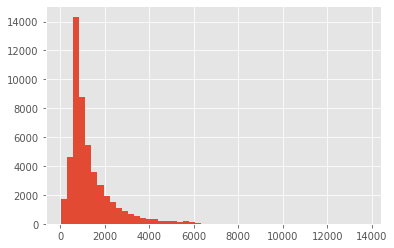

In [6]:
plt.hist([len(s) for s in df.comment], bins=50)
plt.show()

In [0]:
max_features = 22000
maxlen = 1600

tokenizer = Tokenizer()
#fits the comments on the comments
tokenizer.fit_on_texts(df.comment.values)
post_seq= tokenizer.texts_to_sequences(df.comment.values)
post_seq_padded= pad_sequences(post_seq, maxlen=maxlen)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.2, random_state=1)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train

array([[    0,     0,     0, ...,  5579,  5893,   373],
       [    0,     0,     0, ...,  7433,   942, 12576],
       [    0,     0,     0, ...,    29,     1,    55],
       ...,
       [    0,     0,     0, ...,  3935,   454,   156],
       [    0,     0,     0, ...,    10,   210,    11],
       [    0,     0,     0, ...,    69,   541,  1138]], dtype=int32)

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y_train)
y = to_categorical(y)

In [10]:
input_ = Input(shape=(maxlen,))
model = Embedding(len(tokenizer.word_index)+1, 100, input_length=X_train.shape[1])(input_)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(64))(model)
model = Dropout(0.5)(model)
out = Dense(2, activation='softmax')(model)
model = Model(input_, out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1600)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1600, 100)         12425300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 12,510,038
Trainable params: 12,510,038
Non-trainable params: 0
_______________________________________________

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [13]:
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, batch_size=128, y=y, verbose=1, validation_split=0.25, 
          shuffle=True, epochs=3, callbacks=[checkpointer])

Train on 30000 samples, validate on 10000 samples
Epoch 1/3
30000/30000 [==============================] - 1158s 39ms/step - loss: 0.4530 - acc: 0.7781 - val_loss: 0.2783 - val_acc: 0.8900

Epoch 00001: val_acc improved from -inf to 0.89000, saving model to weights-simple.hdf5
Epoch 2/3
30000/30000 [==============================] - 1133s 38ms/step - loss: 0.2188 - acc: 0.9201 - val_loss: 0.2838 - val_acc: 0.8800

Epoch 00002: val_acc did not improve from 0.89000
Epoch 3/3
30000/30000 [==============================] - 1144s 38ms/step - loss: 0.1221 - acc: 0.9591 - val_loss: 0.3307 - val_acc: 0.8903

Epoch 00003: val_acc improved from 0.89000 to 0.89030, saving model to weights-simple.hdf5


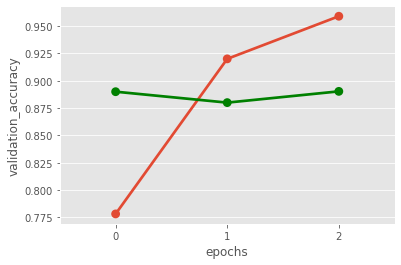

In [14]:
df_result = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df_result, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df_result, fit_reg=False, color='green')

In [27]:
y_test_ = lb.fit_transform(y_test)
y_test_

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [25]:
#get prediction accuarcy for testing dataset 
predicted = model.predict(X_test)
predicted_best = np.argmax(predicted, axis=1)
print (accuracy_score(predicted_best, y_test_))
predicted=pd.DataFrame(data=predicted)

0.8943


In [53]:
twt = ['pathetic movie, actor did a bad job']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen)
print(twt)
sentiment = model.predict(np.array(twt),batch_size=1,verbose = 2)
print(np.argmax(sentiment))
if(np.argmax(sentiment)==0):
  print('negative')
elif(np.argmax(sentiment)==1):
  print('positive')

[[  0   0   0 ...   3  74 293]]
0
negative
